In [1]:
try:
  import qiskit
  import qiskit_aer
  import qiskit_nature
  import qiskit_ibm_runtime
  import pyscf
  import pylatexenc
except:
  !pip install qiskit qiskit-aer qiskit-ibm-runtime qiskit_nature pyscf pylatexenc

# General imports
import numpy as np

# Qiskit Runtime
from qiskit.primitives import Estimator

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper, InterleavedQubitMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit_algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit_algorithms import NumPyMinimumEigensolver, VQE
from qiskit_aer.primitives import Sampler, Estimator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeKolkata



from datetime import datetime


In [3]:
dist = 1.0

In [4]:
# IMPORTANT
def draw_orbitals(problem):
    # Draw orbitals (method provided by Max)
    print(f'Number of particles : {problem.num_particles}')
    print(f'Number of spatial orbitals : {problem.num_spatial_orbitals}')
    print(f'Orbital energies : {problem.orbital_energies}')

    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    for i in range(problem.num_spatial_orbitals):
        if problem.orbital_occupations[i] == 1:
            co = 'tab:blue'
        else:
            co = 'tab:green'

        ax.scatter(i,np.log10(np.abs(problem.orbital_energies[i])), s=15, c=co, marker='o')

    ax.set_xlabel('Orbital', fontsize=15)
    ax.set_ylabel(r'$\log\left(|E|\right)$', fontsize=15)

    ax.scatter(-2,2,s=15, c='tab:blue', marker='o', label='Occupied orbitals')
    ax.scatter(-2,2,s=15, c='tab:green', marker='o', label='Empty orbitals')
    ax.set_xlim(-0.2,problem.num_spatial_orbitals+0.2)
    ax.set_ylim(np.amin(np.log10(np.abs(problem.orbital_energies)))-0.2,
                np.amax(np.log10(np.abs(problem.orbital_energies)))+0.2)
    ax.legend(loc='best', fontsize=15)

def get_freezed_problem(properties, indexes = None):
    # Shortcut for the problem definition
    return FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=indexes
    ).transform(properties)



## other funcs copied

In [5]:
def exact_solver(qubit_op, problem):
  sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
  result = problem.interpret(sol)
  return result

## func for convenient experimental loop

In [6]:
def Experiment(
  molecule,
  orbitals_to_fix,
  optimizer=COBYLA(maxiter=15, tol=0.0001),
  output_info=True,
  if_draw_orbitals=False,
):
  '''
  returns pair of (exact energy, vqe energy)
  '''
  print(f'= = = = = = = = = = = = = = = = = = = = = = = =\nExperiment started: {(datetime.now().time()).strftime("%H:%M:%S")}')  

  molecule = "".join(molecule)[:-1]
  driver = PySCFDriver(
      atom=molecule,
      unit=DistanceUnit.ANGSTROM,
      basis='sto3g',
      spin=0
  )
  properties_molecule = driver.run()
    
  problem = get_freezed_problem(properties_molecule, orbitals_to_fix)

  if (if_draw_orbitals):
    draw_orbitals(problem)
  if (output_info):
    print('. . . . . . . . . . . . . . . . . . .\n')
  
  # exact solver
  device = FakeKolkata()
  coupling_map = device.configuration().coupling_map
  noise_model = NoiseModel.from_backend(device)
  estimator = Estimator(
        backend_options={"coupling_map": coupling_map, "noise_model": noise_model}
    )
  num_particles = problem.num_particles
  num_spatial_orbitals = problem.num_spatial_orbitals
  mapper = ParityMapper(num_particles=num_particles)
  # mapper = JordanWignerMapper()
  qubit_op = mapper.map(problem.second_q_ops()[0])
  
  exact_result = exact_solver(qubit_op, problem)
  if (output_info):
    print(exact_result)
    print(f'Exact solver done: {(datetime.now().time()).strftime("%H:%M:%S")}')
  
  
  # VQE
  init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
  # TODO: maybe try EfficientSU2 instead of UCCSD
  ansatz = UCCSD(
      num_spatial_orbitals, num_particles, mapper, initial_state=init_state
  )
  if (output_info):
    current_time = datetime.now().time()
    print(f'ansatz initialized, {current_time.strftime("%H:%M:%S")}')
    print(f'ansatz.depth = {ansatz.depth()}')
    print(f'num of qubits = {ansatz.num_qubits}')
  
  vqe = VQE(
        estimator,
        ansatz,
        optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )
  vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
  if (output_info):
    current_time = datetime.now().time()
    print(f'VQE compute_minimum_eigenvalue done, {current_time.strftime("%H:%M:%S")}')

  vqe_result = problem.interpret(vqe_calc)
  if (output_info):
    print(
      f"VQE Result: {vqe_result}\n",
      f"Exact Energy: {exact_result}\n"
    )
  return (exact_result, vqe_result)

In [7]:
lioh_dist_domain = np.linspace(0.5, 1.5, 10)

exact_energies = []
vqe_energies = []

for dist in lioh_dist_domain:
  molecule = [
    'Li .0 .0 .0;',
    'H '+str(dist)+' .0 .0;',
    ]
  print(f"{dist = }")
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)
  exact_energies.append(exact_val)
  vqe_energies.append(vqe_val)
  
  

dist = np.float64(0.5)
= = = = = = = = = = = = = = = = = = = = = = = =
Experiment started: 21:58:43
. . . . . . . . . . . . . . . . . . .



/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -10.222973145334
  - computed part:      -0.987444905498
  - FreezeCoreTransformer extracted energy part: -9.235528239836
~ Nuclear repulsion energy (Hartree): 3.17506326552
> Total ground state energy (Hartree): -7.047909879814
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.94486306  0.0  0.0]
 
Exact solver done: 21:58:49
ansatz initialized, 21:58:49
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 22:20:57
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.334657022616
  - computed part:      0.90087121722
  - FreezeCoreTransformer extracted energy part: -9.235528239836
~ Nuclear repulsion energy (Hartree): 3.17506326552
> Total ground state energy (Hartree): -5.159593757096
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.94486306  0.0  0.0]
 
 Exact Energy

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.939814313118
  - computed part:      -1.060775288343
  - FreezeCoreTransformer extracted energy part: -8.879039024775
~ Nuclear repulsion energy (Hartree): 2.597779035425
> Total ground state energy (Hartree): -7.342035277692
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.15483263  0.0  0.0]
 
Exact solver done: 22:21:03
ansatz initialized, 22:21:03
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 22:42:24
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.109328227383
  - computed part:      0.769710797392
  - FreezeCoreTransformer extracted energy part: -8.879039024775
~ Nuclear repulsion energy (Hartree): 2.597779035425
> Total ground state energy (Hartree): -5.511549191958
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.15483263  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.735077887341
  - computed part:      -1.120482587066
  - FreezeCoreTransformer extracted energy part: -8.614595300275
~ Nuclear repulsion energy (Hartree): 2.198120722283
> Total ground state energy (Hartree): -7.536957165058
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.3648022  0.0  0.0]
 
Exact solver done: 22:42:29
ansatz initialized, 22:42:30
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 23:03:26
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.882637843455
  - computed part:      0.73195745682
  - FreezeCoreTransformer extracted energy part: -8.614595300275
~ Nuclear repulsion energy (Hartree): 2.198120722283
> Total ground state energy (Hartree): -5.684517121172
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.3648022  0.0  0.0]
 
 Exact Energy:

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.572013992637
  - computed part:      -1.157138169459
  - FreezeCoreTransformer extracted energy part: -8.414875823178
~ Nuclear repulsion energy (Hartree): 1.905037959312
> Total ground state energy (Hartree): -7.666976033325
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.57477177  0.0  0.0]
 
Exact solver done: 23:03:31
ansatz initialized, 23:03:31
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 23:24:22
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.719033725347
  - computed part:      0.695842097831
  - FreezeCoreTransformer extracted energy part: -8.414875823178
~ Nuclear repulsion energy (Hartree): 1.905037959312
> Total ground state energy (Hartree): -5.813995766035
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.57477177  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.433876712126
  - computed part:      -1.172690757233
  - FreezeCoreTransformer extracted energy part: -8.261185954894
~ Nuclear repulsion energy (Hartree): 1.680915846452
> Total ground state energy (Hartree): -7.752960865675
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.78474134  0.0  0.0]
 
Exact solver done: 23:24:27
ansatz initialized, 23:24:27
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 23:44:59
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.532001411488
  - computed part:      0.729184543406
  - FreezeCoreTransformer extracted energy part: -8.261185954894
~ Nuclear repulsion energy (Hartree): 1.680915846452
> Total ground state energy (Hartree): -5.851085565036
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.78474134  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.312928445782
  - computed part:      -1.172573750215
  - FreezeCoreTransformer extracted energy part: -8.140354695566
~ Nuclear repulsion energy (Hartree): 1.503977336299
> Total ground state energy (Hartree): -7.808951109483
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.99471091  0.0  0.0]
 
Exact solver done: 23:45:04
ansatz initialized, 23:45:04
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 00:05:40
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.446488395436
  - computed part:      0.69386630013
  - FreezeCoreTransformer extracted energy part: -8.140354695566
~ Nuclear repulsion energy (Hartree): 1.503977336299
> Total ground state energy (Hartree): -5.942511059137
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [1.99471091  0.0  0.0]
 
 Exact Energ

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.205219823714
  - computed part:      -1.162007268478
  - FreezeCoreTransformer extracted energy part: -8.043212555236
~ Nuclear repulsion energy (Hartree): 1.360741399509
> Total ground state energy (Hartree): -7.844478424205
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.20468048  0.0  0.0]
 
Exact solver done: 00:05:44
ansatz initialized, 00:05:45
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 00:26:19
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.307220231081
  - computed part:      0.735992324155
  - FreezeCoreTransformer extracted energy part: -8.043212555236
~ Nuclear repulsion energy (Hartree): 1.360741399509
> Total ground state energy (Hartree): -5.946478831572
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.20468048  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.108324144313
  - computed part:      -1.144838431317
  - FreezeCoreTransformer extracted energy part: -7.963485712996
~ Nuclear repulsion energy (Hartree): 1.242416060421
> Total ground state energy (Hartree): -7.865908083892
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.41465005  0.0  0.0]
 
Exact solver done: 00:26:24
ansatz initialized, 00:26:24
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 00:46:57
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.139142208738
  - computed part:      0.824343504258
  - FreezeCoreTransformer extracted energy part: -7.963485712996
~ Nuclear repulsion energy (Hartree): 1.242416060421
> Total ground state energy (Hartree): -5.896726148318
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.41465005  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -9.020515846405
  - computed part:      -1.123657121131
  - FreezeCoreTransformer extracted energy part: -7.896858725274
~ Nuclear repulsion energy (Hartree): 1.143022775587
> Total ground state energy (Hartree): -7.877493070817
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.62461962  0.0  0.0]
 
Exact solver done: 00:47:01
ansatz initialized, 00:47:01
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 01:07:38
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.062740223928
  - computed part:      0.834118501346
  - FreezeCoreTransformer extracted energy part: -7.896858725274
~ Nuclear repulsion energy (Hartree): 1.143022775587
> Total ground state energy (Hartree): -5.919717448341
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.62461962  0.0  0.0]
 
 Exact Ener

/tmp/ipykernel_2798/2831500864.py:30: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device = FakeKolkata()
/tmp/ipykernel_2798/2015473866.py:12: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  exact_val, vqe_val = Experiment(molecule=molecule, optimizer=COBYLA(maxiter=10, tol=0.0001), orbitals_to_fix=None, if_draw_orbitals=False)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.940494382075
  - computed part:      -1.100188333281
  - FreezeCoreTransformer extracted energy part: -7.840306048794
~ Nuclear repulsion energy (Hartree): 1.05835442184
> Total ground state energy (Hartree): -7.882139960235
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.83458919  0.0  0.0]
 
Exact solver done: 01:07:43
ansatz initialized, 01:07:43
ansatz.depth = 1
num of qubits = 8
VQE compute_minimum_eigenvalue done, 01:28:15
VQE Result: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.015549224877
  - computed part:      0.824756823917
  - FreezeCoreTransformer extracted energy part: -7.840306048794
~ Nuclear repulsion energy (Hartree): 1.05835442184
> Total ground state energy (Hartree): -5.957194803037
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [2.83458919  0.0  0.0]
 
 Exact Energy

In [8]:
exact_energies_fixed = []
vqe_energies_fixed = []
for el, vl in zip(exact_energies,vqe_energies):
  exact_energies_fixed.append(el.electronic_energies[0] + el.nuclear_repulsion_energy)
  vqe_energies_fixed.append(vl.electronic_energies[0] + vl.nuclear_repulsion_energy)
  

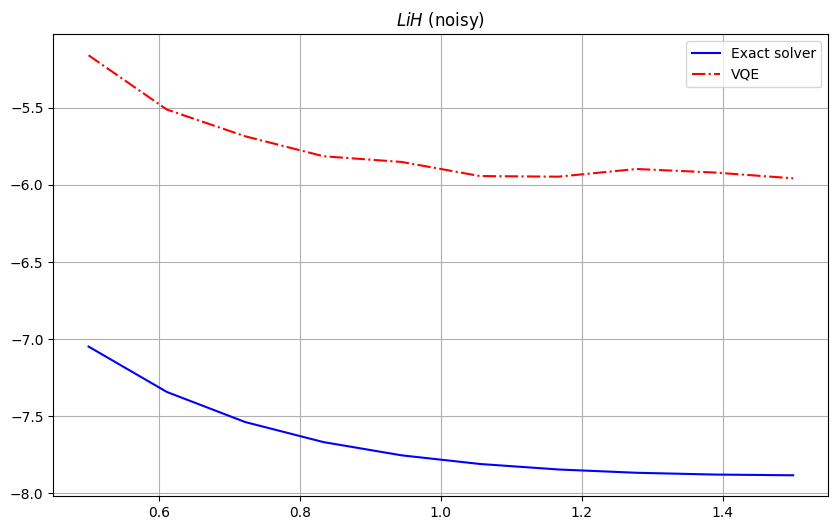

In [12]:
import matplotlib.pyplot as plt

index = 0

plt.figure(figsize=(10, 6))
plt.plot(lioh_dist_domain[index:], exact_energies_fixed[index:], label='Exact solver', linestyle='-', color='b')
plt.plot(lioh_dist_domain[index:], vqe_energies_fixed[index:], label='VQE', linestyle='dashdot', color='r')
plt.title('$LiH$ (noisy)')
plt.grid()
plt.legend(loc='best')
plt.show()

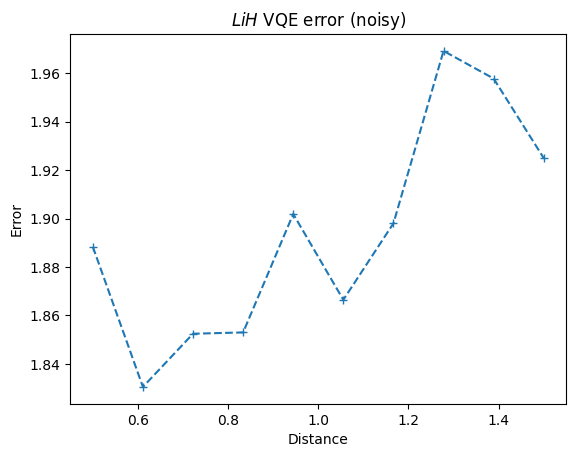

In [13]:
# The error commited at every step remain small

fig, ax = plt.subplots()
# ax.plot(lioh_dist_domain,np.log10(np.abs([vqe_energies[i] - exact_energies_fixed[i] for i in range(len(lioh_dist_domain))])),'+--')
ax.plot(lioh_dist_domain,(np.abs([vqe_energies[i].electronic_energies[0] - exact_energies[i].electronic_energies[0] for i in range(len(lioh_dist_domain))])),'+--')

ax.set_xlabel("Distance")
ax.set_ylabel("Error")
plt.title('$LiH$ VQE error (noisy)')

plt.draw()

In [11]:
np.min(exact_energies_fixed)

np.float64(-7.882139960235327)